# Google Play Store Apps

The data for this project was downloaded from <a href='https://www.kaggle.com/lava18/google-play-store-apps'>Kaggle</a>.<p>
Files:
<ul>
    <li><em>googleplaystore.csv</em> - all the details of the applications on Google Play;</li>
    <li><em>googleplaystore_user_reviews.csv</em> - contains the first 'most relevant' 100 reviews for each app.</li></ul>
<p>The main goal of this project to show data manipulation skills with pandas.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import plotly.graph_objs as go
import seaborn as sns
import warnings

%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
all_apps = pd.read_csv('data_files/google_play_store_apps/googleplaystore.csv')
user_reviews = pd.read_csv('data_files/google_play_store_apps/googleplaystore_user_reviews.csv')

In [4]:
# Check for duplicates
if all_apps.duplicated().sum().any():
    apps = all_apps.drop_duplicates()
else:
    apps = all_apps.copy()

In [5]:
print('Total number of applications in Google Store is {}'.format(len(apps)))

Total number of applications in Google Store is 10358


In [6]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10358 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10358 non-null  object 
 1   Category        10358 non-null  object 
 2   Rating          8893 non-null   float64
 3   Reviews         10358 non-null  object 
 4   Size            10358 non-null  object 
 5   Installs        10358 non-null  object 
 6   Type            10357 non-null  object 
 7   Price           10358 non-null  object 
 8   Content Rating  10357 non-null  object 
 9   Genres          10358 non-null  object 
 10  Last Updated    10358 non-null  object 
 11  Current Ver     10350 non-null  object 
 12  Android Ver     10355 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In columns <strong>Rating, Type, Content Rating, Current Ver, Android Ver</strong> we see missing values.

In [7]:
apps.sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
123,Manicure - nail design,BEAUTY,NaN,119,3.7M,"50,000+",Free,0,Everyone,Beauty,"July 23, 2018",1.3,4.1 and up
895,Trailer Addict Movie Trailers,ENTERTAINMENT,3.9,2646,9.1M,"100,000+",Free,0,Teen,Entertainment,"February 14, 2018",2.2.0,4.2 and up
9886,taxi.eu,TRAVEL_AND_LOCAL,4.1,1865,22M,"100,000+",Free,0,Everyone,Travel & Local,"June 28, 2018",10.7.1388,4.4 and up
10467,FI CFL,FINANCE,3.7,112,3.9M,"10,000+",Free,0,Everyone,Finance,"July 5, 2018",1.1.1,5.0 and up
115,Photo Editor 2018,BEAUTY,4.5,134,17M,"10,000+",Free,0,Everyone,Beauty,"March 1, 2018",1.20,4.0.3 and up


## Clean data
To convert data type object in columns <strong>Installs, Price</strong> and <strong>Size</strong> to int/float we need to remove wrong characters ($ + ,). And we replace text data with appropriate numeric one.

In [8]:
apps[apps['Price'] == 'Everyone']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


After analyzing this row, we decided to drop it, since the data in this row is mixed between the columns. The absence of a line does not have much effect.

In [9]:
index = apps[apps['Price'] == 'Everyone'].index
apps = apps.drop(index)

In [10]:
cols_to_clean = ['Installs', 'Price']

for col in cols_to_clean:
    apps.loc[:, col] = apps.loc[:, col].astype(str).str.replace(r'[\$\+\,]', '', regex=True)
    apps.loc[:, col] = pd.to_numeric(apps.loc[:, col])

In [11]:
def change_format_of_number(item):
    if type(item) == str:
        if 'M' in item:
            return item.replace('M', '')
        elif 'k' in item:
            return float(item.replace('k', '')) / 1000

In [12]:
apps['Size'].mask(apps['Size'] == 'Varies with device', inplace=True)
apps['Size'] = apps['Size'].apply(change_format_of_number)
apps['Size'] = pd.to_numeric(apps['Size'])

## Exploring data
Let's analyse the categories of the apps.

In [13]:
categories = apps['Category']
print('Number of categories = {}'.format(len(categories.unique())))

Number of categories = 33


In [14]:
num_apps_in_category = categories.value_counts()

data_category = [go.Bar(x = num_apps_in_category.index, y = num_apps_in_category.values)]
plotly.offline.iplot(data_category)

### Rating distribution

In [15]:
avg_rating = apps['Rating'].mean()
print('Average app rating = {}'.format(avg_rating))

data_rating = [go.Histogram(x = apps['Rating'])]

layout = {'shapes': [{
                'type': 'line',
                'x0': avg_rating,
                'y0': 0,
                'x1': avg_rating,
                'y1': 1100,
                'line': {'dash': 'dashdot'}
          }]}
plotly.offline.iplot({'data': data_rating, 'layout': layout})

Average app rating = 4.187876743139908


### App size and price
Does the size of an app affect its rating?

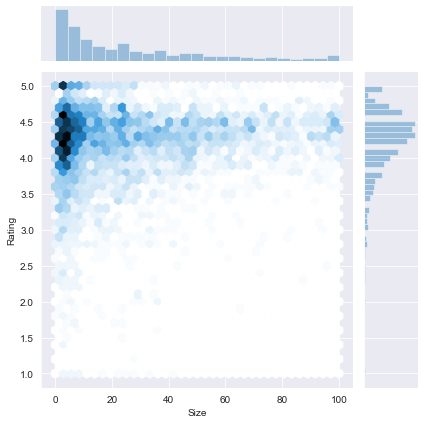

In [16]:
# Filter rows where Rating and Size values are not null and paid.
apps_with_rating_size_present = apps[(~apps['Rating'].isnull()) & (~apps['Size'].isnull())]
paid_apps = apps_with_rating_size_present[apps_with_rating_size_present['Type'] == 'Paid']

# Subset for large categories (more than 250 apps).
large_categories = apps_with_rating_size_present.groupby('Category').filter(lambda x: len(x) >= 250).reset_index()

plot1 = sns.jointplot(x = large_categories['Size'], y = large_categories['Rating'], kind = 'hex')

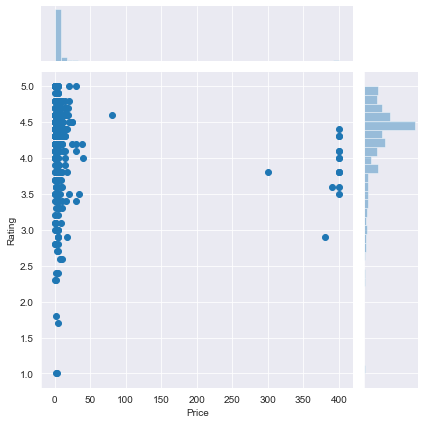

In [17]:
plot2 = sns.jointplot(x = paid_apps['Price'], y = paid_apps['Rating'])

### Relation between Categories and Price

In [18]:
top5_cats = categories.value_counts()[:5]
popular_apps = apps[apps.Category.isin(top5_cats.index)]

,Category,App,Price
4197,FAMILY,most expensive app (H),399.99
5354,FAMILY,I am Rich Plus,399.99
5362,FAMILY,I Am Rich Pro,399.99
5366,FAMILY,I Am Rich,389.99
9719,MEDICAL,EP Cook Book,200.00


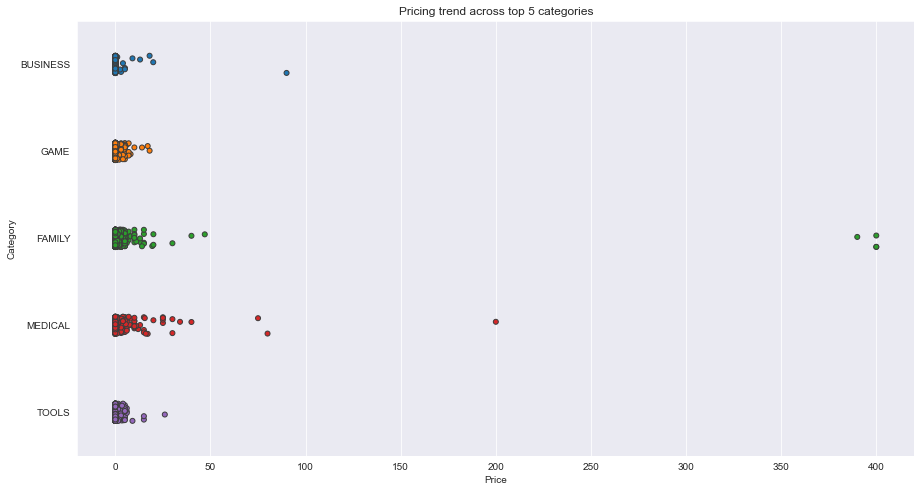

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

ax = sns.stripplot(x = popular_apps['Price'], y = popular_apps['Category'], jitter=True, linewidth=1)
ax.set_title('Pricing trend across top 5 categories')

apps_above_200 = popular_apps[['Category', 'App', 'Price']][popular_apps['Price'] >= 200]
apps_above_200

We found out the data has 4 the most expensive applications. Most of them don't really have a purpose. And these points are outliers.
<p>Let's filter out these apps and re-do our visualization. So the distribution of apps under $20 becomes more clearer.

Text(0.5, 1.0, 'Pricing trend in the top 5 categories with a price below 100')

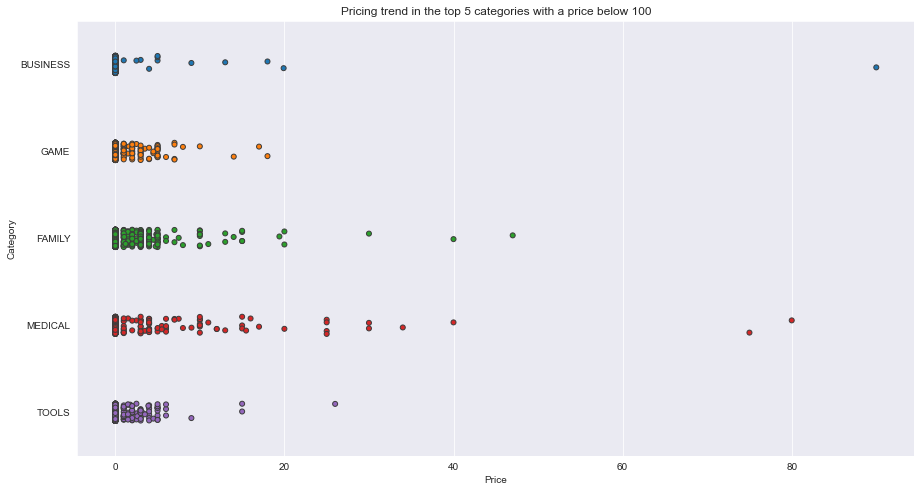

In [20]:
apps_under_100 = popular_apps[popular_apps['Price'] < 100]

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

ax = sns.stripplot(x = 'Price', y = 'Category', data=apps_under_100, jitter=True, linewidth=1)
ax.set_title('Pricing trend in the top 5 categories with a price below 100')

### Popularity of paid apps vs. free apps

In [21]:
paid_apps = go.Box(y = apps[apps['Type'] == 'Paid']['Installs'], name = 'Paid')
free_apps = go.Box(y = apps[apps['Type'] == 'Free']['Installs'], name = 'Free')

layout = go.Layout(title = 'Number of installs paid apps vs. free apps',
                   yaxis = dict(type='log', autorange=True))

plotly.offline.iplot({'data': [paid_apps, free_apps], 'layout': layout})

It turns out that free apps have a relatively more number of installs than paid apps.
### Sentiment analysis

In [22]:
merged_apps = pd.merge(apps, user_reviews, on='App', how='inner')
merged_apps = merged_apps.dropna(subset=['Sentiment', 'Translated_Review'])

Text(0.5, 1.0, 'Sentiment polarity distribution')

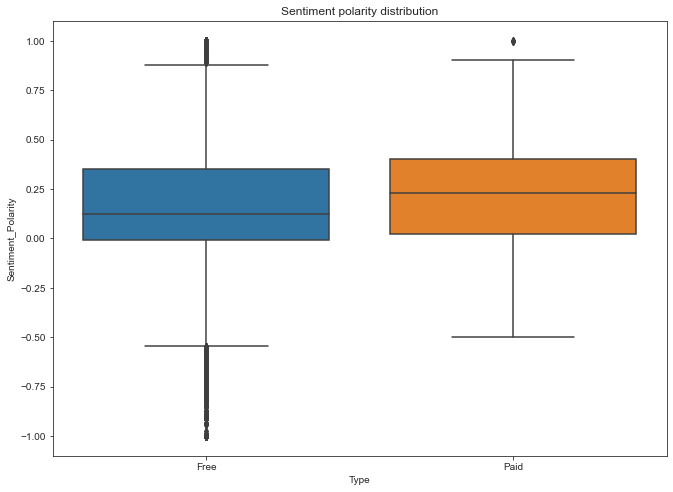

In [23]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

ax = sns.boxplot(x='Type', y='Sentiment_Polarity', data=merged_apps)
ax.set_title('Sentiment polarity distribution')

We see that free apps receive a lot of harsh comments, as indicated by the outliers on the negative y-axis. Reviews for paid apps appear never to be extremely negative. The median polarity score for paid apps is a little higher than free apps.